# Portfolio Construction 03: Maximum Sharpe Ratio Portfolio & Capital Market Line


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd

Folder="C:/Users/msugi/OneDrive/Desktop/DataScience/Courses/05. Investment Management & Machine Learning/01 Intro Portfolio Construction/Resources/data/"
filename4="ind30_m_vw_rets.csv"
Path4=Folder + filename4
   
ind = pd.read_csv(Path4, header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
ind.columns = ind.columns.str.strip()
ind_sub= ind["1996":"2000"]
ind_sub.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1996-01,0.0342,0.0326,0.0182,0.0469,-0.0049,0.0285,-0.0236,0.0595,0.0543,-0.0392,...,0.0233,0.0143,0.0215,0.0121,-0.0012,-0.0065,-0.0146,0.0657,0.0393,0.0283
1996-02,0.0162,0.0561,0.0318,0.0179,0.0233,-0.0044,0.0187,-0.0107,0.0276,0.0024,...,-0.0220,0.0423,0.0677,-0.0104,0.0418,0.0294,0.0553,0.0342,0.0213,0.0151
1996-03,-0.0382,0.0190,-0.0768,0.0108,0.0027,0.0130,0.1149,0.0024,0.0588,0.0268,...,-0.0187,0.0157,-0.0460,0.0306,0.0326,0.0243,0.0825,0.0083,0.0096,0.0500
1996-04,-0.0032,-0.0089,-0.0160,0.0237,0.0285,0.0388,0.0541,-0.0060,-0.0087,0.0346,...,0.0270,0.0820,0.1056,0.0274,0.0265,0.0468,0.0436,0.0271,-0.0108,0.0269
1996-05,0.0550,0.0969,0.0548,0.0279,0.0349,0.0325,0.0805,0.0393,-0.0037,0.0577,...,0.0006,0.0352,0.0418,0.0144,-0.0028,0.0383,0.0511,0.0041,0.0141,0.0432


In [17]:
#Annualize the return
months=ind_sub.shape[0]
ind_sub_anual=(((ind_sub + 1).prod())**(12/months)-1).round(4)
#Calculate Covariance Matrix
cov = ind_sub.cov()


Bring previousely defined functions here:


In [21]:
def portfolio_return(weights, returns):
    return (weights.T @ returns)

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

def plot_efficient_frontier(n_points, ind_sub_anual, cov):
    return_grid = np.linspace(ind_sub_anual.min(), ind_sub_anual.max(), n_points)
    weights_frontier=[weight_minimize_vol(target_return, ind_sub_anual, cov) for target_return in return_grid]
    returns_3=[portfolio_return(w, ind_sub_anual) for w in weights_frontier]
    vol_3=[portfolio_vol(w, cov) for w in weights_frontier]
    efficient_frontier_3 = pd.DataFrame({"Return": returns_3, "Volatility": vol_3})
    
    return efficient_frontier_3.plot.line(x="Volatility", y="Return", style=".-")

import numpy as np
from scipy.optimize import minimize

def weight_minimize_vol(target_return, exptected_return, cov):

#Generate 'weights' from a given 'target_returns'

# number of assets
    n = exptected_return.shape[0]
    print("n=", n)
# Set the Initial Value: let's start from the equal weight
    initial_weight=np.repeat(1/n, n)
    print("initial_weight=", initial_weight)
# Set the contraints
# 1) set the boundary: 0 < w < 1 for a sequence of bounds for every weight
    condition_1_boundary = ((0,1),)*n
    print("condition_1_boundary=", condition_1_boundary)
 

# Condition 2: check if the weights generates a portfolio that meets the target return

    condition_2_return = {'type': 'eq',
                          'args': (exptected_return,),
                          'fun': lambda weights, exptected_return:  target_return - portfolio_return(weights, exptected_return)
                         }

# Condition 3: check if the weights sum to 1:

    condition_3_weights_sum = {'type': 'eq',
                          'fun': lambda weights:  np.sum(weights)-1
                         }
    output = minimize(portfolio_vol, initial_weight, args=(cov,), method="SLSQP", 
                      constraints=(condition_2_return, condition_3_weights_sum), bounds = condition_1_boundary)
    return output.x



Define the function to calculate *__Sharpe Ratio__*

In [92]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def Max_Sharpe_Ratio(risk_free_rate, expected_return, cov):

#Generate 'weights' from a given 'target_returns'

# number of assets
    n = expected_return.shape[0]
    print("n=", n)
# Set the Initial Value: let's start from the equal weight
    initial_weight=np.repeat(1/n, n)
    print("initial_weight=", initial_weight)
# Set the contraints
# Condition 1) set the boundary: 0 < w < 1 for a sequence of bounds for every weight
    condition_1_boundary = ((0,1),)*n
    print("condition_1_boundary=", condition_1_boundary)
 
# Condition 2) check if the weights sum to 1:

    condition_2_weights_sum = {'type': 'eq',
                          'fun': lambda weights:  np.sum(weights)-1
                         }
    #Now in order to maximize Sharpe Ratio, I will minimize the negative of it!
    def negative_Sharpe_Ratio(weights, risk_free_rate, expected_return, cov):
        # calculate the negative of Sharpe Ratio
        return4 = portfolio_return(weights, expected_return)
        vol4 = portfolio_vol(weights, cov)
        Negative_Sharpe_Ratio = - (return4 - risk_free_rate)/vol4
        return Negative_Sharpe_Ratio
    output = minimize(negative_Sharpe_Ratio, initial_weight, args=(risk_free_rate, expected_return, cov), method="SLSQP", 
                      constraints=(condition_2_weights_sum), bounds = condition_1_boundary)
    return output.x


# Maximum Sharpe Ratio Portfolio (Tangent Portfolio)



In [95]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# set the risk free rate
risk_free_rate = 0.1
# weight of MSRP (Maximum Sharpe Ratio Portfolio)
weight_MSRP = Max_Sharpe_Ratio(risk_free_rate, ind_sub_anual, cov)
print("weight_MSRP: ", weight_MSRP)
print("# of weight_MSRP: ", len(weight_MSRP))
# Return of MSRP (Maximum Sharpe Ratio Portfolio)
return_MSRP = portfolio_return(weight_MSRP,  ind_sub_anual)
# Volatility of MSRP (Maximum Sharpe Ratio Portfolio)
vol_MSRP = portfolio_vol(weight_MSRP,  cov)
print(return_MSRP, vol_MSRP)
# y range of Capital Market Line
CML_y = [risk_free_rate, return_MSRP]
# x range of Capital Market Line
CML_x = [0, vol_MSRP]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
n= 30
initial_weight= [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
condition_1_boundary= ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
weight_MSRP:  [5.63675528e-16 4.00049000e-15 5.30227685e-15 4.52169955e-16
 1.15825694e-15 0.00000000e+00 0.00000000e+00 4.55771646e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.45651200e-16 2.33844124e-01 0.00000000e+00 1.84959238e-15
 0.00000000e+00 1.38733060e-01 1.

n= 30
initial_weight= [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
condition_1_boundary= ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
n= 30
initial_weight= [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
condition_1_boundary=

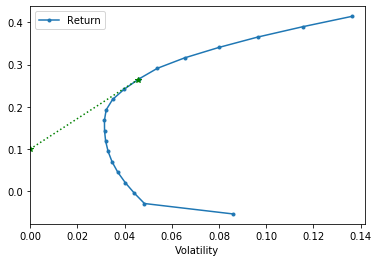

In [96]:
# Draw the CML
ax = plot_efficient_frontier(20, ind_sub_anual, cov)
ax.set_xlim(left=0)
ax.plot(CML_x, CML_y, color="green", marker='*', linestyle="dotted")